<a href="https://colab.research.google.com/github/fjme95/python-para-la-ciencia-de-datos/blob/main/Semana%2010/RNN_Series_de_tiempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instrucciones

Desarrolle un predictor del precio del bitcoin usando una red neuronal recurrente (RNN, por
sus siglas en inglés). El archivo con los datos se puede descargar en este enlance. Este se
puede cargar con pandas.read_feather.


In [ ]:
import pandas as pd
filename = "https://github.com/fjme95/datasets/blob/main/bitcoin_open_prices.feather?raw=true"
pd.read_feather(filename)

,Timestamp,price
0,1325317920,4.39
1,1325346600,4.39
2,1325350740,4.50
3,1325350800,4.58
4,1325391360,4.58
...,...,...
14995,1348881420,12.16
14996,1348881480,12.16
14997,1348881540,12.16
14998,1348882080,12.15


En Google Colab, se puede descargar directamente el archivo con:

In [ ]:
#!wget https://github.com/fjme95/datasets/blob/main/bitcoin_open_prices.feather?raw =true -O bitcoin_open_prices.feather

Realice los siguientes pasos para la predicción:

● Obtenga el primer 70% de los datos para el entrenamiento y los 30% restantes para
las pruebas.

● Escale los datos de entrenamiento usando
sklearn.preprocessing.MinMaxScaler.

● Considere X_train desde el primer elemento al penúltimo del dataset de
entrenamiento y y_train del segundo al último.

● Entrene una red secuencial con las siguientes capas:

○ LSTM con activación sigmoide y dimensionalidad del espacio de salida de 4.

○ Capa densa con salida de dimensión 1.




Para la red neuronal, utilice el optimizador adam y el error cuadrático medio como función
de pérdida.
Una vez que obtenga las predicciones, regrese éstas al espacio original
(sklearn.preprocessing.MinMaxScaler.inverse_transform) y realice una gráfica
comparando los datos reales con los predecidos por la red.

El entregable deberá ser un archivo .ipynb que contenga:

1. Exploración de los datos
2. Los pasos del algoritmo
3. Evaluación de la predicción
4. Gráfica comparando los datos reales con los arrojados por el modelo.
5. Conclusiones.


Extra:

● ¿El modelo “sobre ajustó” los datos?

○ En caso de ser afirmativa la respuesta, agregué una capa de Dropout al
modelo y pruebe con diferentes optimizadores y funciones de activación

#1. Exploración de los datos

##Cargar bibliotecas

In [ ]:
import statsmodels
statsmodels.__version__

!pip install statsmodels #--upgrade

In [ ]:
!pip install scikit-learn==0.24

In [ ]:
import numpy as np #vectores, matrices y operaciones de matrices.
import pandas as pd #manejo y análisis de estructuras de datos.

import tensorflow as tf
from tensorflow import keras

#Visualización de datos.
import matplotlib.pyplot as plt
from matplotlib import pyplot 

import math

#módulo para evaluación de rendimiento.
import sklearn.metrics
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error 

#Estimación de modelos estadísticos y evaluación de tests estadísticos.
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from sklearn.preprocessing import MinMaxScaler  #estandarizar variables.
from sklearn.model_selection import train_test_split #división dataset.

In [ ]:
df_precio=pd.read_feather(filename)

Calculamos la cantidad de datos totales, observamos si hay valores nulos y analizamos el tipo de datos.

In [ ]:
df_precio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  15000 non-null  int64  
 1   price      15000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 234.5 KB


Obtenemos estadísticas sobre los valores del precio del bitcoin, tales como su media, desv. estándar y cuartiles.

In [ ]:
df_precio.describe()

,Timestamp,price
count,1.500000e+04,15000.000000
mean,1.341815e+09,8.624095
std,5.741604e+06,2.727146
min,1.325318e+09,3.800000
25%,1.339254e+09,6.000000
50%,1.343308e+09,8.800000
75%,1.346107e+09,10.970000
max,1.348884e+09,16.410000


A continuación analizamos si la serie de tiempo es estacionaria con el test ADF.

In [ ]:
# ADF Test
result = adfuller(df_precio["price"].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -0.8462215708460848
p-value: 0.8051665207108514
Critial Values:
   1%, -3.430787281716851
Critial Values:
   5%, -2.8617332595612184
Critial Values:
   10%, -2.5668728674069023


Dado que p-value es superior al 0.05, concluimos que la serie no es estacionaria. A pesar de esto podemos intentar pronosticar con redes neuronales recurrentes.

#2. Pasos del algoritmo

##Paso 1. División train-test

Obtenga el primer 70% de los datos para el entrenamiento y los 30% restantes para las pruebas.

In [ ]:
df_precio.set_index(["Timestamp"],inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_precio, test_size=0.3, shuffle=False, random_state=0)

##Paso 2. Escalar datos

● Escale los datos de entrenamiento usando
[sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [ ]:
train_escala = train.copy()
columnas = train.columns

escala = MinMaxScaler()


train_escala[columnas] = escala.fit_transform(train[columnas])
train_escala

,price
Timestamp,
1325317920,0.046788
1325346600,0.046788
1325350740,0.055511
1325350800,0.061856
1325391360,0.061856
...,...
1345602780,0.481364
1345603320,0.480571
1345605540,0.480571


## Paso 3. División x_train, y_train

● Considere X_train desde el primer elemento al penúltimo del dataset de entrenamiento y y_train del segundo al último.

In [ ]:
x_train = train_escala[0:len(train_escala)-1]
x_train

,price
Timestamp,
1325317920,0.046788
1325346600,0.046788
1325350740,0.055511
1325350800,0.061856
1325391360,0.061856
...,...
1345602540,0.490087
1345602780,0.481364
1345603320,0.480571


In [ ]:
y_train = train_escala[1:len(train_escala)]
y_train

,price
Timestamp,
1325346600,0.046788
1325350740,0.055511
1325350800,0.061856
1325391360,0.061856
1325431680,0.082474
...,...
1345602780,0.481364
1345603320,0.480571
1345605540,0.480571


In [ ]:
x_test = test[0:len(test)-1]
x_test

,price
Timestamp,
1345609680,9.90
1345612020,9.80
1345613520,9.81
1345615260,9.78
1345615680,9.87
...,...
1348880160,12.28
1348881420,12.16
1348881480,12.16


In [ ]:
y_test = test[1:len(test)]
y_test

,price
Timestamp,
1345612020,9.80
1345613520,9.81
1345615260,9.78
1345615680,9.87
1345616700,9.75
...,...
1348881420,12.16
1348881480,12.16
1348881540,12.16


##Paso 4. Entrenamiento red secuencial

● Entrene una red secuencial con las siguientes capas:

○ [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) con activación sigmoide y dimensionalidad del espacio de salida de 4.

○ [Capa densa](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) con salida de dimensión 1.

Para la red neuronal, utilice el [optimizador adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) y el error cuadrático medio como función de pérdida. 

In [ ]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

Vectorizamos train y test

In [ ]:
# reshape [muestras, time steps, características]
trainX = np.reshape(x_train.values, (x_train.shape[0], 1, x_train.shape[1]))
trainY = np.reshape(y_train.values, (y_train.shape[0], 1, y_train.shape[1]))

testX = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))
testY = np.reshape(y_test.values, (y_test.shape[0], 1, y_test.shape[1]))

In [ ]:
trainX

array([[[0.04678826]],

       [[0.04678826]],

       [[0.0555115 ]],

       ...,

       [[0.48057098]],

       [[0.48057098]],

       [[0.48374306]]])

In [ ]:
type(x_train.values)

numpy.ndarray

In [ ]:
# Creación y ajuste de LSTM y la capa densa.
model = Sequential()
model.add(LSTM(4, activation='sigmoid', return_sequences=False, return_state=False, input_shape=(1, x_train.shape[1])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
10499/10499 - 12s - loss: 0.0098
Epoch 2/50
10499/10499 - 12s - loss: 1.1135e-04
Epoch 3/50
10499/10499 - 14s - loss: 9.8997e-05
Epoch 4/50
10499/10499 - 12s - loss: 1.0022e-04
Epoch 5/50
10499/10499 - 12s - loss: 9.9217e-05
Epoch 6/50
10499/10499 - 12s - loss: 9.8057e-05
Epoch 7/50
10499/10499 - 12s - loss: 9.7480e-05
Epoch 8/50
10499/10499 - 11s - loss: 9.9191e-05
Epoch 9/50
10499/10499 - 11s - loss: 9.7777e-05
Epoch 10/50
10499/10499 - 11s - loss: 9.7684e-05
Epoch 11/50
10499/10499 - 11s - loss: 9.6227e-05
Epoch 12/50
10499/10499 - 11s - loss: 9.6887e-05
Epoch 13/50
10499/10499 - 11s - loss: 9.8062e-05
Epoch 14/50
10499/10499 - 11s - loss: 9.6356e-05
Epoch 15/50
10499/10499 - 11s - loss: 9.6048e-05
Epoch 16/50
10499/10499 - 11s - loss: 9.7077e-05
Epoch 17/50
10499/10499 - 11s - loss: 9.6293e-05
Epoch 18/50
10499/10499 - 11s - loss: 9.6041e-05
Epoch 19/50
10499/10499 - 11s - loss: 9.5988e-05
Epoch 20/50
10499/10499 - 11s - loss: 9.5236e-05
Epoch 21/50
10499/10499 - 11s - l

##Regresar al espacio original

Una vez que obtenga las predicciones, regrese éstas al espacio original (sklearn.preprocessing.MinMaxScaler.inverse_transform) y realice una gráfica comparando los datos reales con los predecidos por la red.

In [ ]:
trainX

array([[[0.04678826]],

       [[0.04678826]],

       [[0.0555115 ]],

       ...,

       [[0.48057098]],

       [[0.48057098]],

       [[0.48374306]]])

In [ ]:
# Predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
# Invertir predicciones
trainPredict = escala.inverse_transform(trainPredict)
testPredict = escala.inverse_transform(testPredict)

In [ ]:
trainPredict

array([[4.404777],
       [4.404777],
       [4.511657],
       ...,
       [9.92026 ],
       [9.92026 ],
       [9.961194]], dtype=float32)

#3. Evaluación de la predicción

El error absoluto promedio es el promedio de todos los valores absolutos. La fórmula es:

$MAE = \frac1n \sum _{i=1} ^n |x_i - x| $


El error cuadrático medio (mean squared error) nos dice qué tan cerca está una línea de regresión a un conjunto de puntos. Lo hace tomando las distancias desde los puntos a la línea de la regresión (errores) y elevándolos al cuadrado, lo cual se realiza para remover signos negativos. Esta medida toma el promedio del conjunto de los errores y da más peso a diferencias más grandes. Entre menor sea este valor, mejor es la predicción. La fórmula es:

$RMSLE = \sqrt {\frac1n \sum (x - x_i)^2}$

donde:


$x_i$ es la predicción,

$x$ es el valor real.

$n$ es el tamaño de la muestra

In [ ]:
print("\n MAE : \n ", mean_absolute_error(y_train,trainPredict))
print("\n RMSLE : \n ", mean_squared_error(y_train, trainPredict))


 MAE : 
  7.259243855181831

 RMSLE : 
  58.29533216593527


#4. Gráfica comparando los datos reales con los arrojados por el modelo.

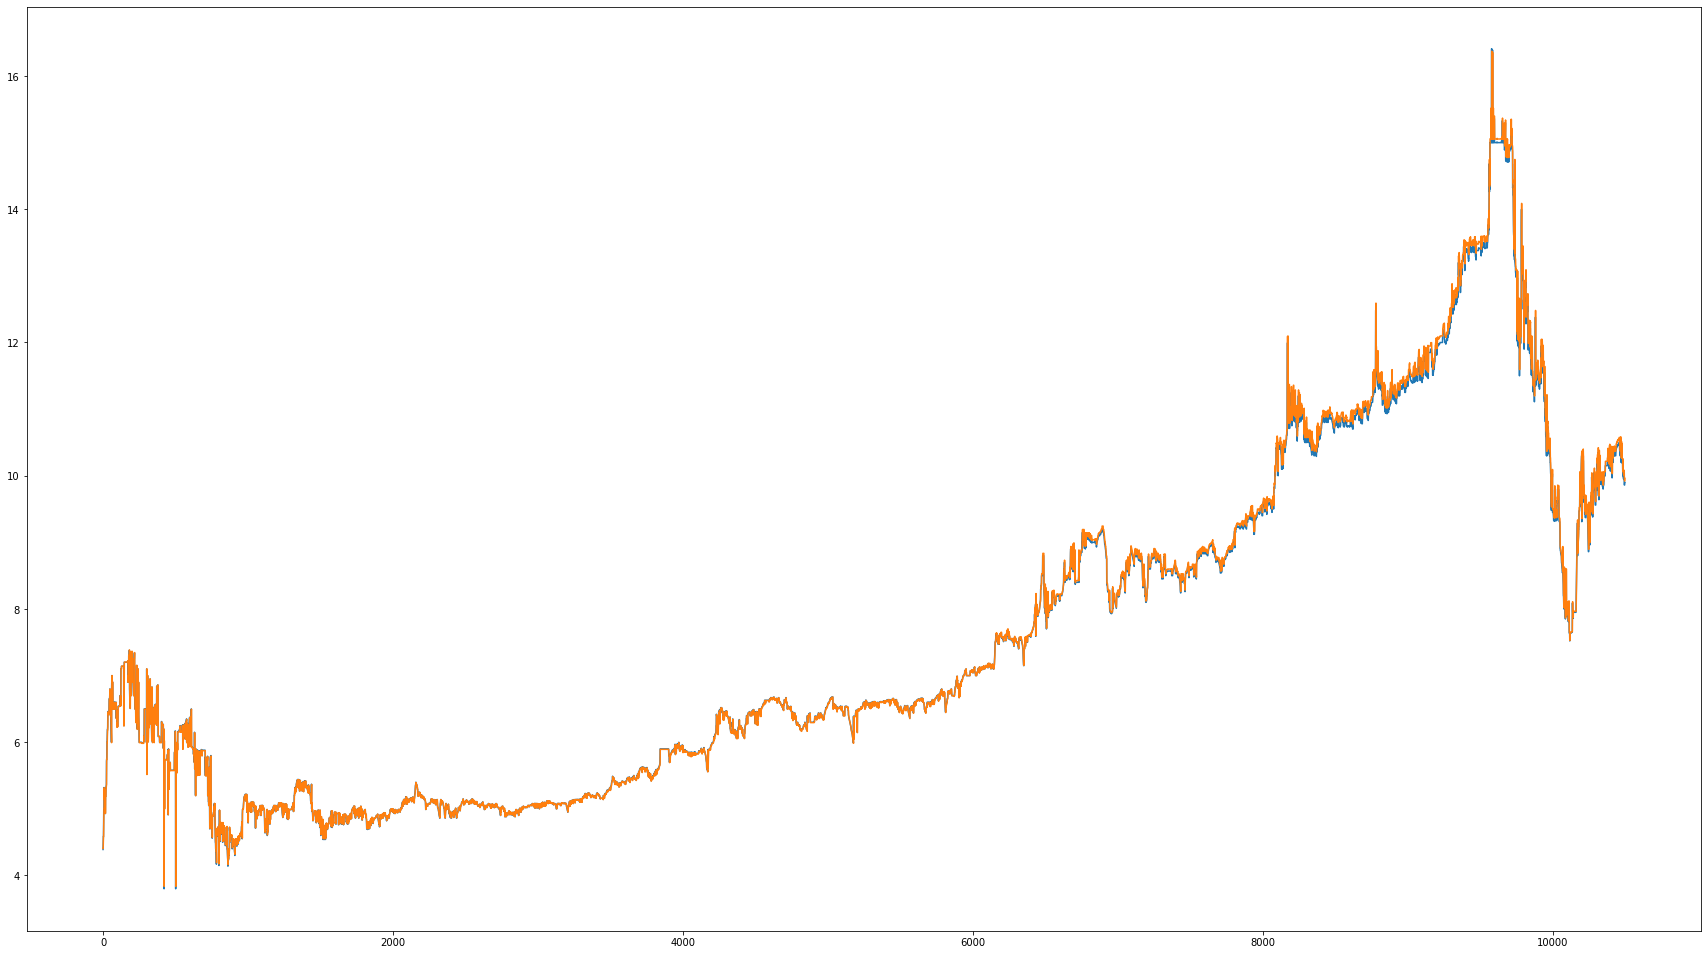

In [ ]:
plt.rcParams["figure.figsize"] = (30,17)
plt.plot(escala.inverse_transform(y_train.reset_index(drop=True)))
plt.plot(trainPredict)
#plt.plot(testPredict)
plt.show()

#5. Conclusiones.

Los datos obtenidos por el modelo son muy parecidos a los reales, por lo que el modelo sobre ajustó a los datos. 

# Extra

● ¿El modelo “sobre ajustó” los datos?

○ En caso de ser afirmativa la respuesta, agregué una capa de Dropout al modelo y pruebe con diferentes optimizadores y funciones de activación

##Observaciones

Se realizaron cambios al modelo y se obtuvieron las siguientes observaciones:

* Al agregar una capa de Dropout al modelo, se atenuó el sobre ajuste a los datos. Así mismo, agregando una capa de Dropout y modificando la pérdida por mean_absolute_percentage_error, se atenuó aún más el sobre ajuste. 

* Al agregar una capa de Dropout al modelo y cambiar la función de activación por tanh, de igual manera se observó una atenuación del sobre ajuste, pero no tanto como con la función sigmoide más dropout.

* Al cambiar a optimizadores como adadelta, adagrad el modelo sub ajustó a los datos.

In [ ]:
# Creación y ajuste de LSTM y la capa densa.
model = Sequential()
model.add(LSTM(4, activation='sigmoid', return_sequences=False, return_state=False, input_shape=(1, x_train.shape[1])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss= 'mean_squared_error', optimizer= 'adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
10499/10499 - 13s - loss: 0.0035
Epoch 2/50
10499/10499 - 12s - loss: 1.0197e-04
Epoch 3/50
10499/10499 - 12s - loss: 1.0277e-04
Epoch 4/50
10499/10499 - 12s - loss: 1.0131e-04
Epoch 5/50
10499/10499 - 12s - loss: 1.0135e-04
Epoch 6/50
10499/10499 - 12s - loss: 1.0092e-04
Epoch 7/50
10499/10499 - 13s - loss: 1.0099e-04
Epoch 8/50
10499/10499 - 15s - loss: 1.0033e-04
Epoch 9/50
10499/10499 - 12s - loss: 1.0025e-04
Epoch 10/50
10499/10499 - 12s - loss: 1.0038e-04
Epoch 11/50
10499/10499 - 13s - loss: 1.0004e-04
Epoch 12/50
10499/10499 - 12s - loss: 9.8632e-05
Epoch 13/50
10499/10499 - 12s - loss: 1.0034e-04
Epoch 14/50
10499/10499 - 12s - loss: 9.8509e-05
Epoch 15/50
10499/10499 - 12s - loss: 9.7697e-05
Epoch 16/50
10499/10499 - 12s - loss: 1.0005e-04
Epoch 17/50
10499/10499 - 12s - loss: 9.7644e-05
Epoch 18/50
10499/10499 - 12s - loss: 9.9861e-05
Epoch 19/50
10499/10499 - 12s - loss: 9.8506e-05
Epoch 20/50
10499/10499 - 12s - loss: 9.8098e-05
Epoch 21/50
10499/10499 - 12s - l

In [ ]:
# Predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
# Invertir predicciones
trainPredict = escala.inverse_transform(trainPredict)
testPredict = escala.inverse_transform(testPredict)

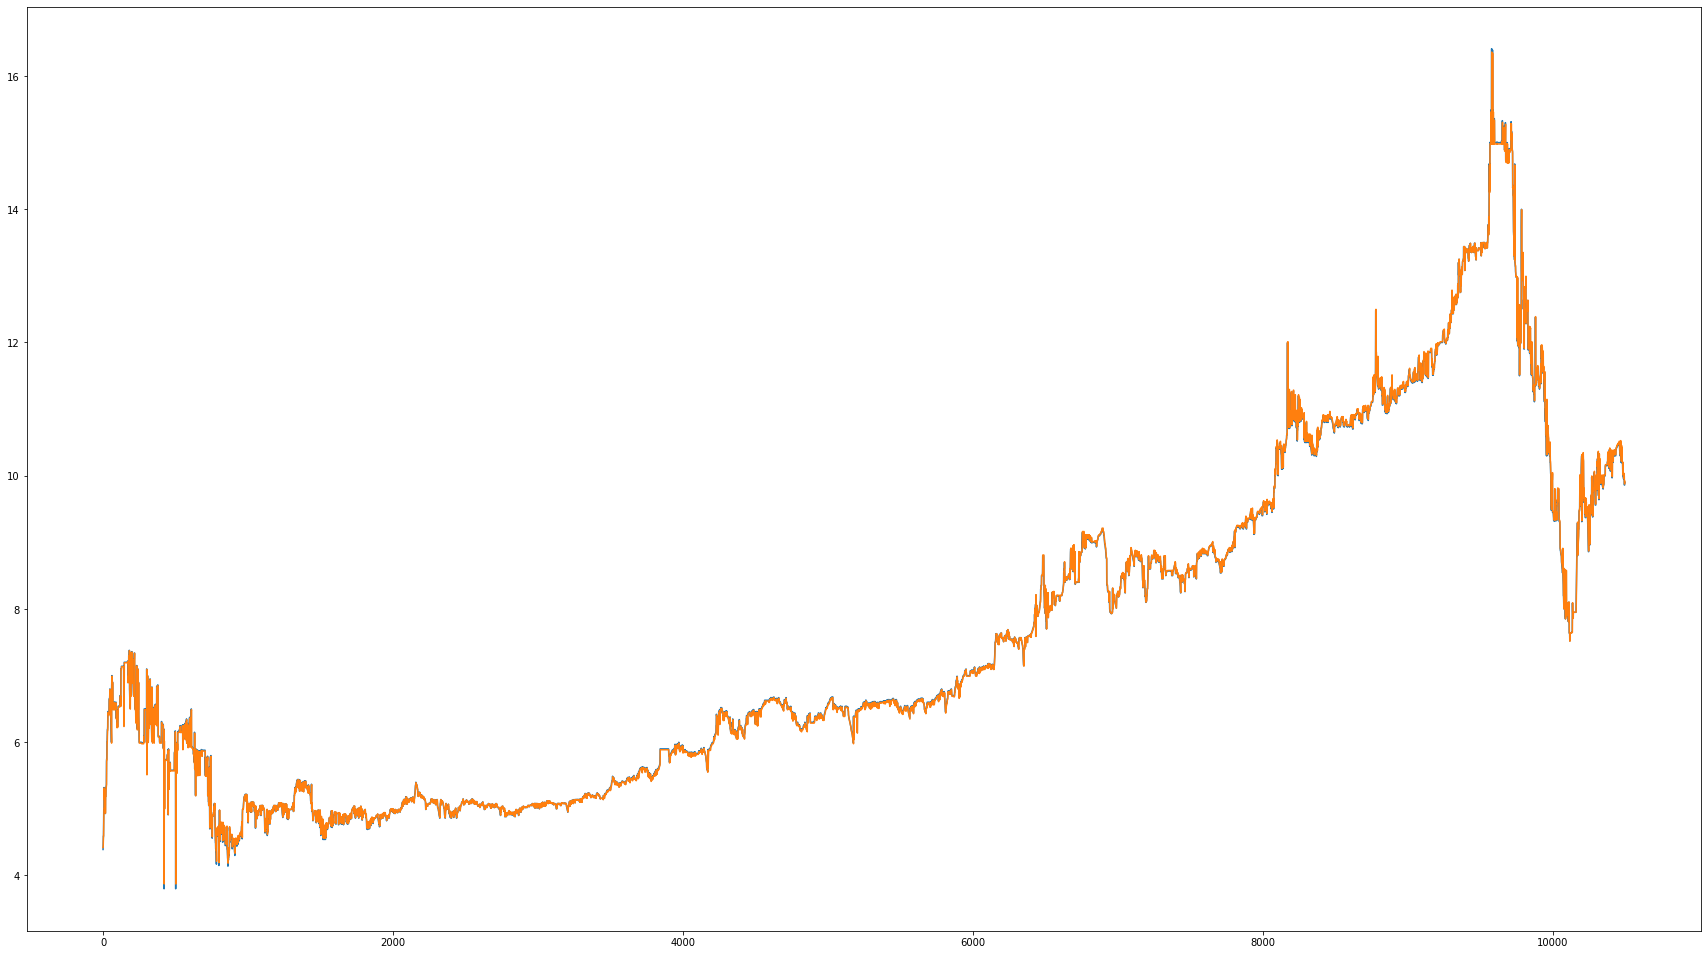

In [ ]:
plt.rcParams["figure.figsize"] = (30,17)
plt.plot(escala.inverse_transform(y_train.reset_index(drop=True)))
plt.plot(trainPredict)
#plt.plot(testPredict)
plt.show()

In [ ]:
print("\n MAE : \n ", mean_absolute_error(y_train,trainPredict))
print("\n RMSLE : \n ", mean_squared_error(y_train, trainPredict))


 MAE : 
  7.237512430436867

 RMSLE : 
  57.851901308307596
